# Toxic comments classification for online store

In [1]:
import pandas as pd
import numpy as np 
np.random.seed(seed=42)
import time
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.display import display
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anshilina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's import and study data. We have to solve the problem of binary classification. We need to get features from text and determine whether comment is a toxic (negative) or not.

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv').drop('Unnamed: 0', axis=1)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv').drop('Unnamed: 0', axis=1)
    
display(df.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
display(df.describe())

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


There are no missing values and duplicates in data frame.

In [5]:
print('Number of missing values:', df.isna().sum().sum())

Number of missing values: 0


In [6]:
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 0


Let's visualize distribution of the target variable. We can observe that classes are imbalanced - there are more positive comments than toxic ones. When fitting models, it is necessary to take into account the imbalance. To do this, we will use special parameters of the models.

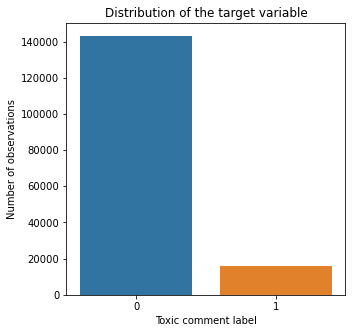

In [12]:
plt.figure(figsize=(5,5))
sns.barplot(data=df, x=df['toxic'].value_counts().index, y=df['toxic'].value_counts().values)
plt.xlabel('Toxic comment label')
plt.ylabel('Number of observations')
plt.title('Distribution of the target variable')
plt.show()

## Data preprocessing

At the first stage, let's get rid of all unnecessary characters except letters using regular expressions.

In [8]:
df['text'] = df['text'].apply(lambda row: "".join(re.sub(r'[^a-zA-Z\' ]', ' ', row)))

Next, let's lemmatize words in sentences. For this we will use the `spacy` library.

In [9]:
spacy_model = spacy.load('en_core_web_sm')
display(spacy_model.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [10]:
disabled_pipes = ['parser', 'ner']
spacy_model = spacy.load('en_core_web_sm', disable=disabled_pipes)

In [11]:
df['text'] = df['text'].apply(lambda row: " ".join([word.lemma_ for word in spacy_model(row)]))

Let's get rid of unnecessary gaps and make all words lowercase.

In [14]:
df['text'] = df['text'].apply(lambda row: ' '.join(row.split()).lower())

In [15]:
display(df['text'].head())

0    explanation why the edit make under my usernam...
1    d'aww he match this background colour i be see...
2    hey man i be really not try to edit war it be ...
3    more i can not make any real suggestion on imp...
4    you sir be my hero any chance you remember wha...
Name: text, dtype: object

Next, let's unload stop words that we will exclude when vectorizing words. To get vectors from words, we will use `TfidfVectorizer`.

In [16]:
stop_words = set(stopwords.words('english')) 
vectorizer_pipe = Pipeline([("vect", TfidfVectorizer(stop_words=stop_words))])

Now let's split sample into train, validation and test.

In [17]:
features = df['text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=True, random_state=42)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.1, shuffle=True, stratify=target_train, random_state=42)

In [18]:
target_test.value_counts()

0    14314
1     1616
Name: toxic, dtype: int64

## Model fitting

We will fit Logistic Regression, Random Rorest Classifier, CatBoost, LightGBM, and XGBoost models. We will consider Decision Tree Classifier as the baseline and will compare quality of predictions made by other classifiers with its. Let's select a probability threshold to get a lower level of false positive responses.

### Decision Tree Classifier

We use the `class_weight` parameter to deal with imbalance.

In [19]:
tree_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])
tree_params = {'tree__max_depth' : range(2, 13, 2)}
tree_model = GridSearchCV(tree_model, param_grid=tree_params, cv=5, scoring='f1', n_jobs=-1)

In [20]:
tree_start = time.time()
tree_model.fit(features_train, target_train)
tree_search_time = time.time() - tree_start

In [21]:
print('Results of grid search.\n')
print(f'Grid search time: {round(tree_search_time/60, 2)} min')
print(f'Fitting time: {round(tree_model.cv_results_["mean_fit_time"][tree_model.best_index_], 5)} s')
print(f'Prediction time: {round(tree_model.cv_results_["mean_score_time"][tree_model.best_index_], 5)} s')
print(f'Best parameters: {tree_model.best_params_}')
print(f'F1 on cross-validation:', tree_model.best_score_)

Results of grid search.

Grid search time: 1.66 min
Fitting time: 19.99173 s
Prediction time: 1.68661 s
Best parameters: {'tree__max_depth': 12}
F1 on cross-validation: 0.5894383381238686


In [21]:
tree_model = tree_model.best_estimator_
preds = tree_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_tree = thresholds[optimal_idx]

In [22]:
tree_predictions = [1 if prob[1] > optimal_threshold_tree else 0 for prob in tree_model.predict_proba(features_valid)]
print(f'F1 on validation:', f1_score(target_valid,  tree_predictions))

F1 on validation: 0.591715976331361


### Random Forest Classifier

Let's train the Random Forest Classifier, search parameters and evaluate the model on the validation set.

In [23]:
forest_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('forest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
forest_params = {
    'forest__max_depth' : range(2,13,2),
    'forest__n_estimators': range(10,90,10),
}
forest_model = GridSearchCV(forest_model, param_grid=forest_params, cv=3, scoring='f1', n_jobs=-1)

In [24]:
forest_start = time.time()
forest_model.fit(features_train, target_train)
forest_search_time = time.time() - forest_start

In [25]:
print('Results of grid search.\n')
print(f'Grid search time: {round(forest_search_time/60, 2)} min')
print(f'Fitting time: {round(forest_model.cv_results_["mean_fit_time"][forest_model.best_index_], 5)} s')
print(f'Prediction time: {round(forest_model.cv_results_["mean_score_time"][forest_model.best_index_], 5)} s')
print(f'Best parameters: {forest_model.best_params_}')
print(f'F1 on cross-validation:', forest_model.best_score_)

Results of grid search.

Grid search time: 5.71 min
Fitting time: 13.17692 s
Prediction time: 3.149 s
Best parameters: {'forest__max_depth': 12, 'forest__n_estimators': 80}
F1 on cross-validation: 0.3652188181943883


The quality of predictions made by Random Forest Classifier is lower than results of Decision Tree Classifier if the threshold is not adjusted.

In [26]:
forest_model = forest_model.best_estimator_
preds = forest_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_forest = thresholds[optimal_idx]

In [27]:
forest_predictions = [1 if prob[1] > optimal_threshold_forest else 0 for prob in forest_model.predict_proba(features_valid)]
print(f'F1 on validation:', f1_score(target_valid,  forest_predictions))

F1 on validation: 0.6547934823796893


### Logistic Regression

Now let's fit linear classifier - Logistic Regression.

In [28]:
log_reg = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('log', LogisticRegression(class_weight='balanced', solver='liblinear'))
])
log_params = {
    'log__penalty':['l1', 'l2'],
    'log__C':range(5,20,5),
}
log_reg = GridSearchCV(log_reg, param_grid=log_params, cv=3, scoring='f1', n_jobs=-1)

In [29]:
log_start = time.time()
log_reg.fit(features_train, target_train)
log_search_time = time.time() - log_start

In [30]:
print('Results of grid search.\n')
print(f'Grid search time: {round(log_search_time, 2)} s')
print(f'Fitting time: {round(log_reg.cv_results_["mean_fit_time"][log_reg.best_index_], 5)} s')
print(f'Prediction time: {round(log_reg.cv_results_["mean_score_time"][log_reg.best_index_], 5)} s')
print(f'Best parameters: {log_reg.best_params_}')
print(f'F1 on cross-validation:', log_reg.best_score_)

Results of grid search.

Grid search time: 64.97 s
Fitting time: 13.38114 s
Prediction time: 5.85869 s
Best parameters: {'log__C': 10, 'log__penalty': 'l2'}
F1 on cross-validation: 0.7633101740809153


In [31]:
log_reg = log_reg.best_estimator_
preds = log_reg.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_log = thresholds[optimal_idx]

In [32]:
log_predictions = [1 if prob[1] > optimal_threshold_log else 0 for prob in log_reg.predict_proba(features_valid)]
print(f'F1 on validation:', f1_score(target_valid,  log_predictions))

F1 on validation: 0.7903168387326451


Next we fit gradient boosting models. Firstly, we calculate weights of each class that we will use in models to solve the imbalance problem while fitting Cat Boost and LightGBM.

In [33]:
classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

### Cat Boost Classifier

In [63]:
cat_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('cat', CatBoostClassifier(class_weights=class_weights, random_seed=42, loss_function='Logloss', silent=True))
])

In [64]:
cat_start = time.time()
cat_model.fit(features_train, target_train)
cat_fit_time = time.time() - cat_start

In [65]:
cat_start = time.time()
cat_model.predict(features_valid)
cat_pred_time = time.time() - cat_start

In [66]:
print('Fitting results.\n')
print(f'Fitting time: {round(cat_fit_time/60, 5)} min')
print(f'Prediction time: {round(cat_pred_time, 5)} s')
print('F1 on validation:', f1_score(target_valid, cat_model.predict(features_valid)))

Fitting results.

Fitting time: 10.85897 min
Prediction time: 0.9528 s
F1 on validation: 0.7552795031055901


In [38]:
preds = cat_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_cat = thresholds[optimal_idx]

In [39]:
cat_model['cat'].set_probability_threshold(optimal_threshold_cat)

In [40]:
cat_predictions = [1 if prob[1] > optimal_threshold_cat else 0 for prob in cat_model.predict_proba(features_valid)]
print(f'F1 on validation:', f1_score(target_valid,  cat_predictions))

F1 on validation: 0.7777777777777778


The quality is high enough.

### LGBM Classifier

In [56]:
lgbm_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('lgbm', LGBMClassifier(class_weight=class_weights, random_state=42, n_jobs=-1))
])
lgbm_params = {
    'lgbm__learning_rate': [0.03, 0.1],
    'lgbm__n_estimators': range(80, 100, 5),
}
lgbm_model = GridSearchCV(lgbm_model, param_grid=lgbm_params, cv=3, scoring='f1', n_jobs=-1)

In [57]:
lgbm_start = time.time()
lgbm_model.fit(features_train, target_train)
lgbm_search_time = time.time() - lgbm_start

In [58]:
print('Results of grid search.\n')
print(f'Grid search time: {round(lgbm_search_time/60, 2)} min')
print(f'Fitting time: {round(lgbm_model.cv_results_["mean_fit_time"][lgbm_model.best_index_]/60, 5)} min')
print(f'Prediction time: {round(lgbm_model.cv_results_["mean_score_time"][lgbm_model.best_index_], 5)} s')
print(f'Best parameters: {lgbm_model.best_params_}')
print(f'F1 on cross-validation:', lgbm_model.best_score_)

Results of grid search.

Grid search time: 4.55 min
Fitting time: 1.14895 min
Prediction time: 7.15554 s
Best parameters: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 95}
F1 on cross-validation: 0.7357299436257833


In [44]:
lgbm_model = lgbm_model.best_estimator_
preds = lgbm_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_lgbm = thresholds[optimal_idx]

In [45]:
lgbm_predictions = [1 if prob[1] > optimal_threshold_lgbm else 0 for prob in lgbm_model.predict_proba(features_valid)]
print(f'F1 on validation:', f1_score(target_valid,  lgbm_predictions))

F1 on validation: 0.7679597701149425


The quality of the LGBM model on the validation is high enough but lower than quality of Cat Boost. However, the learning rate is higher than learning rate of Cat Boost.

### XGB Classifier

In [59]:
xgb_class_weight = float(np.sum(target_train == 0) / np.sum(target_train == 1))

In [60]:
xgb_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('xgb', XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=xgb_class_weight))
])
xgb_params = {
    'xgb__max_depth': range(6,10,2),
    'xgb__n_estimators': range(50,90,10),
}
xgb_model = GridSearchCV(xgb_model, param_grid=xgb_params, cv=3, scoring='f1', n_jobs=-1)

In [61]:
xgb_start = time.time()
xgb_model.fit(features_train, target_train)
xgb_search_time = time.time() - xgb_start

In [62]:
print('Results of grid search.\n')
print(f'Grid search time: {round(xgb_search_time/60, 2)} min')
print(f'Fitting time: {round(xgb_model.cv_results_["mean_fit_time"][xgb_model.best_index_]/60, 5)} min')
print(f'Prediction time: {round(xgb_model.cv_results_["mean_score_time"][xgb_model.best_index_], 5)} s')
print(f'Best parameters: {xgb_model.best_params_}')
print(f'F1 on cross-validation:', xgb_model.best_score_)

Results of grid search.

Grid search time: 8.3 min
Fitting time: 2.86375 min
Prediction time: 2.63444 s
Best parameters: {'xgb__max_depth': 8, 'xgb__n_estimators': 80}
F1 on cross-validation: 0.7426201577028179


In [50]:
xgb_model = xgb_model.best_estimator_
preds = xgb_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_xgb = thresholds[optimal_idx]

In [51]:
xgb_predictions = [1 if prob[1] > optimal_threshold_xgb else 0 for prob in xgb_model.predict_proba(features_valid)]
print(f'F1 on validation:', f1_score(target_valid,  xgb_predictions))

F1 on validation: 0.7640369580668088


The quality of the model on the validation is not high enough, after selecting the threshold it is lower than quality of Cat Boost or LightGBM. At the same time, learning rate of XGBoost is slow.

**Summary:** Logistic Regression has the best quality on validation. The results of the models comparison are presented in the table. F1 scores for CatBoost and Logistic Regression are close – 0.78 and 0.79 respectively. However, learning rate and prediction time of Logistic Regression is higher. Therefore, we will use Logistic Regression model to make final classification of the comments.

|Model|Fitting time|Prediction time| F1 score on validation|
|:---|:---|:---|:---|
|Logistic Regression|13.38 s|5.86 s|0.79|
|CatBoost|11.86 min|0.98 s| 0.78|
|LightGBM|1.16 min|7.15 s|0.77|
|XGBoost|2.86 min|2.63 s| 0.76|
|Random Forest Classifier|13.18 s|3.15 s|0.65|
|Decision Tree Classifier|20.68 s|1.85 s|0.59|

## Model testing

In [52]:
print('Predictions of the Logistic Regression on the test sample.\n')
log_test_pred = [1 if prob[1] > optimal_threshold_log else 0 for prob in log_reg.predict_proba(features_test)]
print('F1 score on test:', f1_score(target_test, log_test_pred))

Predictions of the Logistic Regression on the test sample.

F1 score on test: 0.7919463087248322


In [53]:
proba_test = log_reg.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

AUC-ROC: 0.9709045150008924


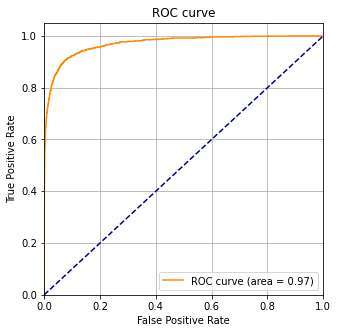

In [54]:
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Conclusion

In this project, we classified comments into toxic and non-toxic. The target quality of the prediction model was achieved - the quality on the test sample (F1 score) is 0.79. To achieve the target quality, we selected the optimal threshold value.

At the first stage, we obtained features from the text. Unnecessary characters were removed from the text, it was lemmatized, and then vectorized using the TF-IDF formula that shows uniqueness of the token (word) in the text relative to the entire corpus. While preprocessin data, we discovered imbalance of the classes - there are more non-toxic comments than toxic ones. We tried to overcome this problem by setting the appropriate parameters of the models.

Finally, we fitted six models - Decision Tree Classifier, Random Forest Classifier, Logistic Regression, and gradient boosting models: CatBoost, LightGBM, XGBoost. We compared the quality of those models and their learning rate and prediction time. As the result, Logistic Regression was chosen as the final model and we suggest to use it to detect toxic comments.